# TSFS12 Hand-in exercise 5, solution: Learning predictive driver models with neural networks

This exercise is based on data from the I-80 data set from the U.S. Department of Transportation. The data can be downloaded from the course directory in 
Lisam, and are available in the directory /courses/tsfs12/i80_data in the student labs at campus. 

I-80 data set citation: U.S. Department of Transportation Federal Highway Administration. (2016). Next Generation Simulation (NGSIM) Vehicle
Trajectories and Supporting Data. [Dataset]. Provided by ITS DataHub through Data.transportation.gov. Accessed 2020-09-29 from http://doi.org/10.21949/1504477. More details about the data set are 
available through this link.  

Make initial imports. The exercise requires python packages numpy, torch, scikit-learn, and pandas.

In [1]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, tensor
import torch
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from seaborn import despine
from i80_utility import plot_road, lane_bounds, plot_prediction, load_i80_features
from i80_utility import load_i80_trajectories, get_trajectory_from_datapoint

In [2]:
%matplotlib inline

# Introduction
The raw data used in the exercise is available from https://www.its.dot.gov/data/, US Department of Transportation, Intelligent Transport Systems datahub. More specifically, we will use the I80 data from the NGSIM program. The data was collected through a network of synchronized digital video cameras and then transcribed to vehicle trajectory data from the video. This vehicle trajectory data provided the precise location of each vehicle within the study area in 10 Hz, resulting in detailed lane positions and locations relative to other vehicles.

https://data.transportation.gov/Automobiles/Next-Generation-Simulation-NGSIM-Vehicle-Trajector/8ect-6jqj

The raw data is described in the file ```I-80_Metadata_Documentation.pdf```. There are predefined functions for reading the raw data (and units are converted to SI-units).

From the raw trajectory data, we have designed features to be able to build predictive models. The data needed for this exercise can be downloaded from Lisam, thus you _do not_ have to download anything outside of Lisam.

First, define where the data resides, on your computer or if you are working in the student labs. The variable ```i80_data_dir``` points to the directory where the data directory ```i80_data``` is located.

In [3]:
i80_data_dir = './'  # data downloaded in the current directory
# i80_data_dir = '/courses/tsfs12/'  # student labs

Create a random number generator (with a specified seed so that results are reproducible)

In [4]:
rg = np.random.default_rng(seed=1891)

# Load I-80 feature data

Based on the I80 data, we have designed features to be able to build predictive models. Each datapointhas 41 features. The feature data consists of 95591 datapoints and consists of three variables:
* x - The feature data, a (95591 x 41)-matrix.
* y - True label for each datapoint.
* info - Information which trajectory, dataset, and time-stamp the datapoint corresponds to.

The feature data is described in more detail in the handin documentation and the file ```features.md```.

In [5]:
x, y, info = load_i80_features(i80_data_dir)
x = tensor(x).float()
y = tensor(y).long()
print(f"Read {x.shape[0]} datapoints with {x.shape[1]} features.")

Read 95591 datapoints with 41 features.


Show how many datapoints correspond to switching lane left, right, and staying in the same lane.

In [6]:
print(f"Left: {(y == 0).sum()}, Straight: {(y == 1).sum()}, Right: {(y == 2).sum()}")

Left: 963, Straight: 94324, Right: 304


# Factor out validation data set

The next step is to create a validation data-set and carefully ensure that there is no leakage of validation datapoints into the training dataset. First, collect indices for all datapoints corresponding to each class.

In [7]:
left_class_idx = (y == 0).nonzero()
straight_class_idx = (y == 1).nonzero()
right_class_idx = (y == 2).nonzero()

By random, select M datapoints from each class to be included in the dataset. The validation dataset will then be balanced. Due to the large imbalance, we can't include too many datapoints from each class, then very few would be available for training. Experiment with this number M.

In [8]:
M = 50
val_class_idx = (rg.choice(left_class_idx, M, replace=False),
                 rg.choice(straight_class_idx, M, replace=False),
                 rg.choice(right_class_idx, M, replace=False))
val_index = np.concatenate(val_class_idx).squeeze()

# Balance training data by resampling

Due to the severe class imbalance in data, some measure need to be taken. Here, data is balanced by oversampling the underrepresented classes to weigh those datapoints higher. The code below samples M datapoints, _with replacement_, from each class (excluding the validation data). Experiment also with the number M.

In [9]:
M = 1500  # Number of samples from each class
train_class_idx = (rg.choice(np.setdiff1d(left_class_idx, val_class_idx[0]), M),
                   rg.choice(np.setdiff1d(straight_class_idx, val_class_idx[1]), M),
                   rg.choice(np.setdiff1d(right_class_idx, val_class_idx[2]), M))

train_index = np.concatenate(train_class_idx).squeeze()

Collect data points and lables for traing and validation in tensors ```x_train```, ```y_train```, ```x_val```, ```y_val```.

In [10]:
x_train = x[train_index]
y_train = y[train_index]
x_val = x[val_index]
y_val = y[val_index]

# Normalize data

Last step before building models, normalize data so that each feature has mean 0 and standard deviation 1.

In [11]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

x_val = (x_val - mu) / std
x_train = (x_train - mu) / std

Do not forget to normalize data also when doing predictions.

# Define a training loop

Here is a simple training loop. Study the code, it is fully implemented but it is expected that you understand how it works (not implementation details).

In [14]:
def train_model(model, epochs, train_data, val_data):
    """A simple training loop
    
    arguments:
        model -- The model to train; must have properties loss_fun and optimizer
        epochs -- Number of epochs to train
        train_data -- Dataloader for training data
        val_data -- Dataloader for test data
    
    returns:
        history -- dictionary with keys  {train_loss, train_acc, val_loss, val_acc}
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []}

    def train_loop():
        size = len(train_data.dataset)
        num_batches = len(train_data)
        train_loss, train_acc = 0., 0.
        for xi, yi in train_data:
            pred = model(xi)
            loss = model.loss_fun(pred, yi)

            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item() / num_batches
            train_acc += (pred.argmax(1) == yi).sum().item()
        train_acc /= size
        
        return train_loss, train_acc
    
    
    def val_loop():
        size = len(val_data.dataset)
        num_batches = len(val_data)
        val_loss, val_acc = 0, 0
        model.eval()
        with torch.no_grad():
            for xi, yi in val_data:
                pred = model(xi)
                val_loss += model.loss_fun(pred, yi).item()
                val_acc += (pred.argmax(1) == yi).sum().item()
        model.train()
        val_loss /= num_batches
        val_acc /= size
        
        return val_loss, val_acc
    
    for k in range(epochs):
        print(f"Epoch {k + 1:>2}/{epochs}: ", end="")

        # Training loop
        train_loss, train_acc = train_loop()
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation loop
        val_loss, val_acc = val_loop()
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"loss: {train_loss:>.4f} - accuracy: {train_acc:>0.3f} - val_loss {val_loss:>.4f} - val_accuracy: {val_acc:>0.3f}")

    return history

# Define the neural network model for intent prediction

Define the intent prediction model class. Experiment by adding layers in the arguments to ```nn.Sequential()``` below.  Basic layers, that are sufficient here, are 
* [```linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) (clickable-link)
* [```relu```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
* [```softmax```](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax)

 Below is a very small, functioning, network. You are encouraged to experiment with layers and regularization, for example [```dropout```](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout). Experiment and see what happens with training and validation performance. Imporant that input dimension is 41 (number of features) and that the output dimension 3 (number of classes) with a ```Softmax```-layer.

In [17]:
class IntentPredictionModel(nn.Module):
    def __init__(self, lr=1e-3):
        """Prediction model
        
        arguments:
        lr -- Learning rate for optimizer (default: 1e-3)
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(41, 3),
            nn.ReLU(),
            nn.Linear(3, 3),
            nn.Softmax(1)
        )
        
        self.loss_fun = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=lr, weight_decay=0)
        

    def forward(self, x):
        return self.network(x)

model = IntentPredictionModel(lr=1e-3)
summary(model)

Layer (type:depth-idx)                   Param #
IntentPredictionModel                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       126
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       12
│    └─Softmax: 2-4                      --
├─CrossEntropyLoss: 1-2                  --
Total params: 138
Trainable params: 138
Non-trainable params: 0

In [15]:
dl_train = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
dl_val = DataLoader(TensorDataset(x_val, y_val), batch_size=32, shuffle=True)

h = train_model(model, 30, dl_train, dl_val)

Epoch  1/30: loss: 1.0988 - accuracy: 0.356 - val_loss 1.0786 - val_accuracy: 0.373
Epoch  2/30: loss: 1.0530 - accuracy: 0.483 - val_loss 1.0111 - val_accuracy: 0.593
Epoch  3/30: loss: 0.9912 - accuracy: 0.591 - val_loss 0.9526 - val_accuracy: 0.647
Epoch  4/30: loss: 0.9304 - accuracy: 0.668 - val_loss 0.9153 - val_accuracy: 0.633
Epoch  5/30: loss: 0.8856 - accuracy: 0.693 - val_loss 0.8900 - val_accuracy: 0.640
Epoch  6/30: loss: 0.8580 - accuracy: 0.716 - val_loss 0.8728 - val_accuracy: 0.687
Epoch  7/30: loss: 0.8394 - accuracy: 0.736 - val_loss 0.8506 - val_accuracy: 0.700
Epoch  8/30: loss: 0.8257 - accuracy: 0.756 - val_loss 0.8426 - val_accuracy: 0.733
Epoch  9/30: loss: 0.8138 - accuracy: 0.770 - val_loss 0.8304 - val_accuracy: 0.740
Epoch 10/30: loss: 0.8043 - accuracy: 0.782 - val_loss 0.8254 - val_accuracy: 0.753
Epoch 11/30: loss: 0.7958 - accuracy: 0.794 - val_loss 0.8137 - val_accuracy: 0.767
Epoch 12/30: loss: 0.7888 - accuracy: 0.801 - val_loss 0.8121 - val_accuracy

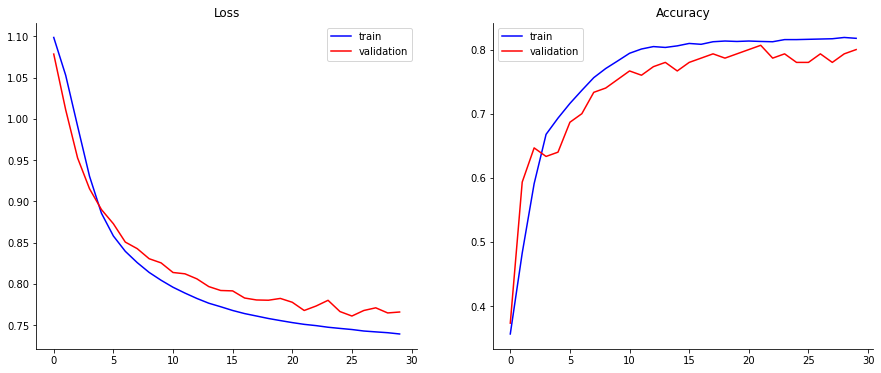

In [16]:
plt.figure(10, clear=True, figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(h["train_loss"], 'b', label='train')
plt.plot(h["val_loss"], 'r', label='validation')
plt.legend()
plt.title("Loss")
despine()

plt.subplot(1, 2, 2)
plt.plot(h["train_acc"], 'b', label='train')
plt.plot(h["val_acc"], 'r', label='validation')
plt.legend()
plt.title("Accuracy")
despine()

Put model in evaluation mode, i.e., deactivate any randomness in the model, e.g., drop-out layers.

In [17]:
_ = model.eval()

Predict 10 random samples (remember {0, 1, 2} = {change left, lane keep, change right})

In [18]:
M = 10
for _ in range(10):
    xi_index = rg.choice(val_index, 1)
    yhat = model((x[xi_index] - mu) / std).data.numpy()[0]
    with np.printoptions(precision=4):
        print(f"Prediction: {yhat} -> {np.argmax(yhat)} (true: {int(y[xi_index][0])})")

Prediction: [2.7099e-07 2.8042e-03 9.9720e-01] -> 2 (true: 1)
Prediction: [1.2732e-15 4.8316e-04 9.9952e-01] -> 2 (true: 2)
Prediction: [9.9996e-01 3.7576e-05 1.1964e-23] -> 0 (true: 0)
Prediction: [3.5574e-08 9.6744e-01 3.2556e-02] -> 1 (true: 0)
Prediction: [9.6250e-04 9.9542e-01 3.6136e-03] -> 1 (true: 1)
Prediction: [9.9924e-01 7.5711e-04 5.8264e-21] -> 0 (true: 0)
Prediction: [3.3313e-06 9.9994e-01 5.6997e-05] -> 1 (true: 1)
Prediction: [1.8057e-06 1.0000e+00 3.6544e-10] -> 1 (true: 1)
Prediction: [1.1572e-23 1.1112e-05 9.9999e-01] -> 2 (true: 2)
Prediction: [9.9759e-01 2.4059e-03 1.4211e-14] -> 0 (true: 0)


Compute the confusion matrix for training and validation data using the imported ```confusion_matrix``` function. Function ```np.argmax``` can also be useful.

In [18]:
# YOUR CODE HERE
# C = confusion_matrix(arguments)

Compute accuracy, precision and recall using the computed confusion matrix.

In [19]:
# YOUR CODE HERE

# Evaluate on validation trajectories

Below is a simple visualization of model predictions given the vehicle trajectories. First, load all trajectories from the I-80 dataset.

## Load and explore trajectories

In [51]:
trajectories = load_i80_trajectories(i80_data_dir)

print(f"0400pm-0415pm: {len(trajectories[0])} trajectories.")
print(f"0500pm-0515pm: {len(trajectories[1])} trajectories.")
print(f"0515pm-0530pm: {len(trajectories[2])} trajectories.")

0400pm-0415pm: 1725 trajectories.
0500pm-0515pm: 1416 trajectories.
0515pm-0530pm: 1242 trajectories.


The trajectories are stores as pandas dataframes. For example, the first samples of the first trajectory in the first data set (0400pm-0415pm) has the following data

In [52]:
trajectories[0][0].head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway
0,1,12,884,1113433136100,5.147561,14.699085,4.359756,1.95122,2,13.719512,0.0,1,0,0,0.0,0.0
1,1,13,884,1113433136200,5.164024,15.080183,4.359756,1.95122,2,13.719512,0.0,1,0,0,0.0,0.0
2,1,14,884,1113433136300,5.180183,15.460976,4.359756,1.95122,2,13.719512,0.0,1,0,0,0.0,0.0
3,1,15,884,1113433136400,5.196646,15.842378,4.359756,1.95122,2,13.719512,0.0,1,0,0,0.0,0.0
4,1,16,884,1113433136500,5.212805,16.223476,4.359756,1.95122,2,13.719512,0.0,1,0,0,0.0,0.0


Plot N=100 random trajectories from the first data-set.

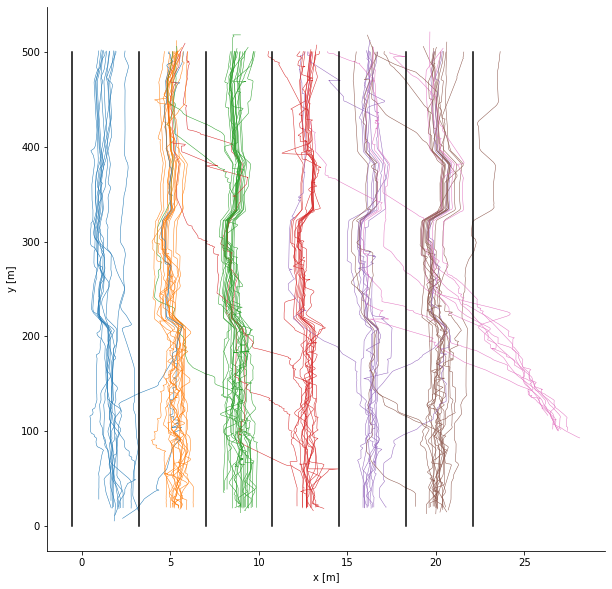

In [53]:
N = 100
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(10, clear=True, figsize=(10, 10))
for trajectory_idx in rg.choice(range(len(trajectories[0])), N):
    trajectory = trajectories[0][trajectory_idx]
    plt.plot(trajectory.Local_X, trajectory.Local_Y, color=colors[trajectory.Lane_ID.iloc[0]], lw=0.5)
plot_road()
despine()
plt.xlabel('x [m]')
_ = plt.ylabel('y [m]')

## Visualize model predictions

Plot random trajectories from the validation dataset. The function ```get_trajectory_from_datapoint``` finds which trajectory contains the prediction point, and also returns the index to all points on the trajectory included in the feature dataset.

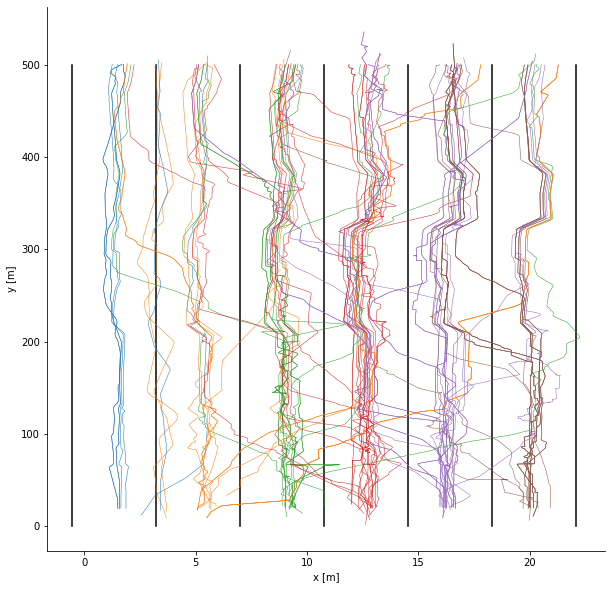

In [54]:
N = 100  # Number of trajectories
plt.figure(30, clear=True, figsize=(10, 10))
plot_road()
for idx in rg.choice(val_index, N):
    trajectory, _ = get_trajectory_from_datapoint(idx, info, trajectories)
    plt.plot(trajectory.Local_X, trajectory.Local_Y, color=colors[trajectory.Lane_ID.iloc[0]], lw=0.5)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
despine()

Select a point by random from the validation dataset, find the corresponding trajectory, and make predictions along the trajectory.

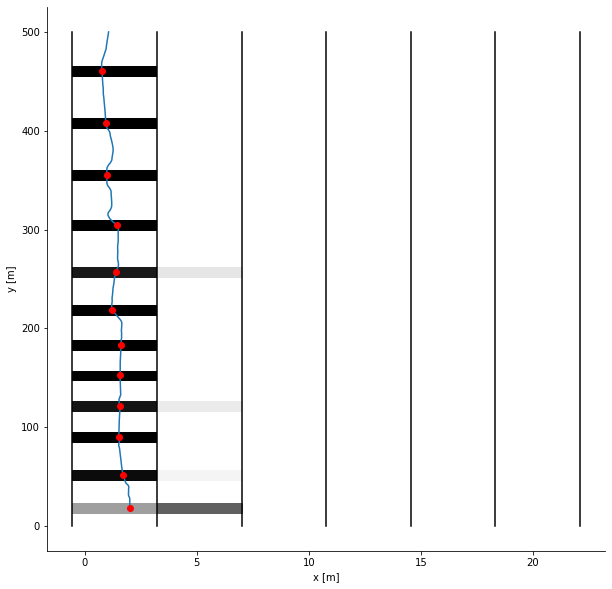

In [103]:
val_i = rg.choice(val_index)
trajectory, data_points = get_trajectory_from_datapoint(val_i, info, trajectories)

x_norm = (x[data_points] - mu) / std
pred = model(x_norm).data.numpy()

plt.figure(40, clear=True, figsize=(10, 10))
plot_road()
plt.plot(trajectory.Local_X, trajectory.Local_Y)
for ti, lane_change_prediction in zip(info[data_points][:, 1], pred):
    pos_prediction = (trajectory.Local_X.iloc[ti], trajectory.Local_Y.iloc[ti])
    plot_prediction(pos_prediction, lane_change_prediction, lane_bounds)
    plt.plot(trajectory.Local_X.iloc[ti], trajectory.Local_Y.iloc[ti], 'ro')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
despine()